# modelの評価
## testデータを用いてそれぞれのモデルで正解率を出す

### 関数の仕様
* モデルのパスとtestディレクトリのパスを引数に入れたら600枚程度の画像で検証をする  
#### 返り値
* 全体における正解率 scaler
* 各予測のone hotベクトルの累積和(20, 20)
* 各画像ごとの分布確率(20, 20)
* 正解ラベル名、画像のパス、間違えた画像の全てのラベルに対する予測確率(dataframe)(N, 22)

In [34]:
import os
import numpy as np
import pandas as pd
from keras import models
from keras.preprocessing import image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
INPUT_SIZE = 256

In [35]:
def evaluate_model(model_path, test_pathes, classes, fname):
    model = models.load_model(model_path)
    classes_num = len(classes)
    cumulative_sum = np.zeros((classes_num, classes_num))
    probability = np.zeros((classes_num, classes_num))
    all_pictures_num = 0
    accuracy = 0
    columns = classes + ["LABEL", "PATH"]
    df1 = pd.DataFrame(columns=columns)
    df_all1 = pd.DataFrame(columns=columns)
    acc_dist = np.array([])
    for i, test_path in tqdm(enumerate(test_pathes),total=len(classes)):
        pictures_num = len(test_path)
        all_pictures_num += pictures_num
        for img_path in test_path:
            img = image.load_img(img_path, target_size=(INPUT_SIZE, INPUT_SIZE))
            x = image.img_to_array(img)/255.0
            x = np.expand_dims(x, axis=0)
            preds = model.predict(x)
            ans = np.argmax(preds[0])
            acc_dist = np.insert(acc_dist, len(acc_dist), preds[0][i])
            cumulative_sum[i][ans] += 1
            probability[i][ans] += 1
            accuracy += int(i == ans)
            content = list(preds[0])+[classes[i],img_path]
            df_all2 = pd.DataFrame( [content], columns=columns)
            df_all1 = pd.concat([df_all1, df_all2]) 
            if i != ans:
                # content = list(preds[0])+[classes[i],img_path]
                df2 = pd.DataFrame( [content], columns=columns)
                df1 = pd.concat([df1, df2])
        probability[i] /= pictures_num
    np.savetxt('acc_matrix/acc_matrix'+fname+'.csv', probability)
    df1.to_csv('incorrect/df'+fname+'.csv', index=False)
    df_all1.to_csv('probabilities_df_all/df_all'+fname+'.csv', index=False)
    np.savetxt('acc_dist/acc_dist'+fname+'.csv', acc_dist)
    return accuracy/all_pictures_num, cumulative_sum, probability, df1, df_all1, acc_dist

In [36]:
base_dir = 'mini_pictures'
test_dir = os.path.join(base_dir,'test')

mini_metadata = pd.read_csv('mini_metadata.csv',index_col=0)
classes = list(mini_metadata["make_model"].value_counts().index)
classes = sorted(classes)
classes_num = len(classes)
print(classes)
# print(classes_num) # = 20

test_pathes = []
for i in range(classes_num):
    pre_path = os.path.join(test_dir, classes[i])
    test_pathes.append([os.path.join(pre_path, fname) for fname in  os.listdir(pre_path)])

['Audi-a3', 'Audi-a5', 'Audi-q5', 'BMW-1-series', 'BMW-4-series', 'BMW-x3', 'Honda-pilot', 'Jeep-wrangler', 'MINI-clubman', 'MINI-countryman', 'Mazda-mazda5', 'Mercedes-Benz-gla', 'Mercedes-Benz-glk', 'Mitsubishi-outlander', 'Nissan-370z', 'Nissan-quest', 'Nissan-rogue-select', 'Subaru-outback', 'Toyota-tacoma', 'Volkswagen-cc']


# ファインチューニングをしたモデルの正解率

In [4]:
model_path = 'models/VGG16_mini_extended_fine2.h5'
acc, cumulative_sum, probability, df1, df_all1, acc_dist1 = evaluate_model(model_path, test_pathes, classes, '1')
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None
print(acc)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:14<00:00, 26.54s/it]


0.995475113122172


In [5]:
df_all1.reset_index(drop=True,inplace=True)
print(df_all1.shape)

(663, 22)


In [6]:
df1.reset_index(drop=True,inplace=True)
df1.head(df1.shape[0])

,Audi-a3,Audi-a5,Audi-q5,BMW-1-series,BMW-4-series,BMW-x3,Honda-pilot,Jeep-wrangler,MINI-clubman,MINI-countryman,Mazda-mazda5,Mercedes-Benz-gla,Mercedes-Benz-glk,Mitsubishi-outlander,Nissan-370z,Nissan-quest,Nissan-rogue-select,Subaru-outback,Toyota-tacoma,Volkswagen-cc,LABEL,PATH
0,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.93,0.00,0.00,0.00,0.00,0.00,0.00,BMW-x3,mini_pictures\test\BMW-x3\BMW-x3_e24ee4eccccf_...
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.69,0.00,0.00,0.25,0.00,0.00,0.00,0.06,0.00,0.00,Mitsubishi-outlander,mini_pictures\test\Mitsubishi-outlander\Mitsub...
2,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.01,0.00,0.00,Subaru-outback,mini_pictures\test\Subaru-outback\Subaru-outba...


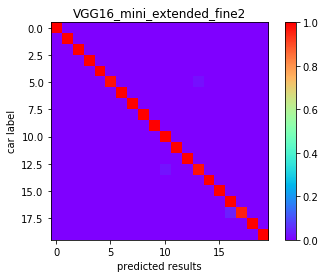

In [7]:
fig = plt.figure()
im = plt.imshow(probability, "rainbow")
plt.title("VGG16_mini_extended_fine2")
plt.xlabel("predicted results")
plt.ylabel("car label")
fig.colorbar(im)

In [8]:
prob = pd.DataFrame(probability, columns=classes)
prob.head(20)

,Audi-a3,Audi-a5,Audi-q5,BMW-1-series,BMW-4-series,BMW-x3,Honda-pilot,Jeep-wrangler,MINI-clubman,MINI-countryman,Mazda-mazda5,Mercedes-Benz-gla,Mercedes-Benz-glk,Mitsubishi-outlander,Nissan-370z,Nissan-quest,Nissan-rogue-select,Subaru-outback,Toyota-tacoma,Volkswagen-cc
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# VGG16の転移学習のみをしたモデルの正解率

In [9]:
model_path2 = 'models/VGG16_mini_3.h5'
acc2, cumulative_sum2, probability2, df2, df_all2, acc_dist2 = evaluate_model(model_path2, test_pathes, classes,'2')
# np.set_printoptions(precision=2, floatmode='fixed')
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None
print(acc2)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:12<00:00, 24.68s/it]


0.9834087481146304


In [12]:
df_all2.reset_index(drop=True,inplace=True)
print(df_all2.shape)

(663, 22)


In [13]:
df2.reset_index(drop=True,inplace=True)
df2.head(df2.shape[0])

,Audi-a3,Audi-a5,Audi-q5,BMW-1-series,BMW-4-series,BMW-x3,Honda-pilot,Jeep-wrangler,MINI-clubman,MINI-countryman,Mazda-mazda5,Mercedes-Benz-gla,Mercedes-Benz-glk,Mitsubishi-outlander,Nissan-370z,Nissan-quest,Nissan-rogue-select,Subaru-outback,Toyota-tacoma,Volkswagen-cc,LABEL,PATH
0,0.17,0.02,0.00,0.28,0.48,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,BMW-1-series,mini_pictures\test\BMW-1-series\BMW-1-series_b...
1,0.02,0.76,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,BMW-4-series,mini_pictures\test\BMW-4-series\BMW-4-series_7...
2,0.00,0.00,0.11,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00,0.00,BMW-x3,mini_pictures\test\BMW-x3\BMW-x3_3d7a1030deeb_...
3,0.00,0.00,0.75,0.00,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,BMW-x3,mini_pictures\test\BMW-x3\BMW-x3_3d7a1030deeb_...
4,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.53,0.00,0.00,Honda-pilot,mini_pictures\test\Honda-pilot\Honda-pilot_82d...
5,0.00,0.00,0.00,0.00,0.00,0.04,0.17,0.00,0.00,0.00,0.53,0.00,0.14,0.00,0.00,0.11,0.00,0.00,0.00,0.00,Honda-pilot,mini_pictures\test\Honda-pilot\Honda-pilot_ba0...
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.50,0.00,0.02,0.00,0.00,0.26,0.00,0.00,0.00,0.00,0.00,MINI-clubman,mini_pictures\test\MINI-clubman\MINI-clubman_4...
7,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.09,0.81,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.01,0.00,0.00,MINI-clubman,mini_pictures\test\MINI-clubman\MINI-clubman_7...
8,0.01,0.00,0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Mercedes-Benz-gla,mini_pictures\test\Mercedes-Benz-gla\Mercedes-...
9,0.00,0.00,0.70,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,Subaru-outback,mini_pictures\test\Subaru-outback\Subaru-outba...


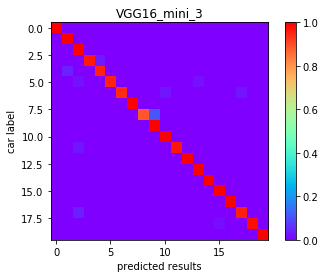

In [14]:
fig = plt.figure()
im = plt.imshow(probability2, "rainbow")
plt.title("VGG16_mini_3")
plt.xlabel("predicted results")
plt.ylabel("car label")
fig.colorbar(im)

In [15]:
prob2 = pd.DataFrame(probability2, columns=classes)
prob2.head(20)

,Audi-a3,Audi-a5,Audi-q5,BMW-1-series,BMW-4-series,BMW-x3,Honda-pilot,Jeep-wrangler,MINI-clubman,MINI-countryman,Mazda-mazda5,Mercedes-Benz-gla,Mercedes-Benz-glk,Mitsubishi-outlander,Nissan-370z,Nissan-quest,Nissan-rogue-select,Subaru-outback,Toyota-tacoma,Volkswagen-cc
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.97,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.05,0.00,0.00,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.02,0.00,0.00,0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.94,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# 自作モデルの正解率

In [51]:
model_path3 = 'models/simplest_cnn_model_mini_1.h5'
acc3, cumulative_sum3, probability3, df3, df_all3, acc_dist3 = evaluate_model(model_path3, test_pathes, classes, "3")
# np.set_printoptions(precision=2, floatmode='fixed')
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None
print(acc3)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.20s/it]


0.8431372549019608


In [52]:
df_all3.reset_index(drop=True,inplace=True)
print(df_all3.shape)
df_all3.tail()

(663, 22)


,Audi-a3,Audi-a5,Audi-q5,BMW-1-series,BMW-4-series,BMW-x3,Honda-pilot,Jeep-wrangler,MINI-clubman,MINI-countryman,Mazda-mazda5,Mercedes-Benz-gla,Mercedes-Benz-glk,Mitsubishi-outlander,Nissan-370z,Nissan-quest,Nissan-rogue-select,Subaru-outback,Toyota-tacoma,Volkswagen-cc,LABEL,PATH
658,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,Volkswagen-cc,mini_pictures\test\Volkswagen-cc\Volkswagen-cc...
659,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,Volkswagen-cc,mini_pictures\test\Volkswagen-cc\Volkswagen-cc...
660,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,Volkswagen-cc,mini_pictures\test\Volkswagen-cc\Volkswagen-cc...
661,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,Volkswagen-cc,mini_pictures\test\Volkswagen-cc\Volkswagen-cc...
662,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,Volkswagen-cc,mini_pictures\test\Volkswagen-cc\Volkswagen-cc...


In [53]:
df3.reset_index(drop=True,inplace=True)
df3.head(df3.shape[0])

,Audi-a3,Audi-a5,Audi-q5,BMW-1-series,BMW-4-series,BMW-x3,Honda-pilot,Jeep-wrangler,MINI-clubman,MINI-countryman,Mazda-mazda5,Mercedes-Benz-gla,Mercedes-Benz-glk,Mitsubishi-outlander,Nissan-370z,Nissan-quest,Nissan-rogue-select,Subaru-outback,Toyota-tacoma,Volkswagen-cc,LABEL,PATH
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Audi-a3,mini_pictures\test\Audi-a3\Audi-a3_5ee6ce7e5db...
1,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Audi-a3,mini_pictures\test\Audi-a3\Audi-a3_5ee6ce7e5db...
2,0.34,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,Audi-a3,mini_pictures\test\Audi-a3\Audi-a3_6fbd22ce727...
3,0.03,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Audi-a3,mini_pictures\test\Audi-a3\Audi-a3_c53e374fdd7...
4,0.00,0.02,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Audi-a5,mini_pictures\test\Audi-a5\Audi-a5_17a1f1ab0ac...
5,0.40,0.00,0.00,0.00,0.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Audi-a5,mini_pictures\test\Audi-a5\Audi-a5_17a1f1ab0ac...
6,0.57,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.02,0.00,0.04,0.00,0.00,0.19,0.00,0.00,0.00,0.00,0.00,Audi-a5,mini_pictures\test\Audi-a5\Audi-a5_3edf4f51b42...
7,0.87,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,Audi-a5,mini_pictures\test\Audi-a5\Audi-a5_6a548b4d774...
8,0.98,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Audi-a5,mini_pictures\test\Audi-a5\Audi-a5_75bc924cc8c...
9,0.00,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.56,Audi-a5,mini_pictures\test\Audi-a5\Audi-a5_c9222952965...


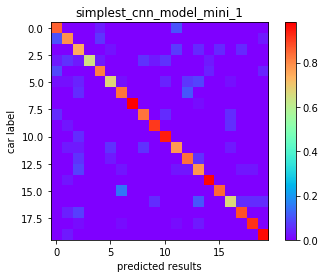

In [54]:
fig = plt.figure()
im = plt.imshow(probability3, cmap="rainbow")
plt.title("simplest_cnn_model_mini_1")
plt.xlabel("predicted results")
plt.ylabel("car label")
fig.colorbar(im)

In [55]:
prob3 = pd.DataFrame(probability3, columns=classes)
prob3.head(20)

,Audi-a3,Audi-a5,Audi-q5,BMW-1-series,BMW-4-series,BMW-x3,Honda-pilot,Jeep-wrangler,MINI-clubman,MINI-countryman,Mazda-mazda5,Mercedes-Benz-gla,Mercedes-Benz-glk,Mitsubishi-outlander,Nissan-370z,Nissan-quest,Nissan-rogue-select,Subaru-outback,Toyota-tacoma,Volkswagen-cc
0,0.86,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.10,0.79,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03
2,0.00,0.00,0.75,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.05,0.00,0.05,0.00,0.05,0.00,0.00
3,0.03,0.06,0.03,0.65,0.03,0.00,0.00,0.00,0.06,0.03,0.06,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00
4,0.09,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.05
5,0.02,0.02,0.04,0.00,0.00,0.67,0.02,0.00,0.00,0.00,0.04,0.00,0.07,0.09,0.00,0.00,0.02,0.00,0.00,0.00
6,0.00,0.00,0.06,0.00,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
8,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.83,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00
9,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00


# モデル評価のためのヒストグラム作成
* acc_dist...各カラムの正解と予測された確率のnp配列
* plot histogram
* acc_distのmean, stdを計算しbar plot with errorbar

0.9955801101277647 0.9683156347526884 0.1995577239636513
0.060243361434697204 0.1108814340073005 0.3916426119204546


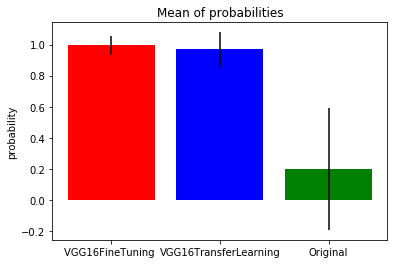

In [42]:
acc_dist1 = np.array(pd.read_csv('acc_dist/acc_dist1.csv'))
acc_dist2 = np.array(pd.read_csv('acc_dist/acc_dist2.csv'))
acc_dist3 = np.array(pd.read_csv('acc_dist/acc_dist3.csv'))

acc1_m = np.mean(acc_dist1)
acc2_m = np.mean(acc_dist2)
acc3_m = np.mean(acc_dist3)
acc1_s = np.std(acc_dist1)
acc2_s = np.std(acc_dist2)
acc3_s = np.std(acc_dist3)
print(acc1_m,acc2_m,acc3_m)
print(acc1_s,acc2_s,acc3_s)

label=['VGG16FineTuning ','VGG16TransferLearning','Original']
x = [1,2,3]
y = [acc1_m, acc2_m, acc3_m]
yerr = np.array([acc1_s, acc2_s, acc3_s])
plt.bar(x, y, yerr=yerr, ecolor="black", color=["red", "blue", "green"],tick_label=label)
# plt.bar(x, y, yerr=yerr, ecolor="black", color=["red", "blue", "green"],label=label)

plt.title('Mean of probabilities')
plt.ylabel('probability')

# plt.bar(1, acc1_m, yerr=acc1_s, ecolor="black", color="red",label='VGG16 fine tuning')
# plt.bar(2, acc2_m, yerr=acc2_s, ecolor="black", color="blue",label='VGG16 transfer learning')
# plt.bar(3, acc3_m, yerr=acc3_s, ecolor="black", color="green",label='original')
# plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize=11)
plt.savefig('results_pictures/acc_bars.png')

In [43]:
a_min = 0.975
a_max = 1.0
# acc_dist11 = np.clip(acc_dist1,a_max=a_max,a_min=a_min).reshape(-1,)
# acc_dist22 = np.clip(acc_dist2,a_max=a_max,a_min=a_min).reshape(-1,)
# acc_dist33 = np.clip(acc_dist3,a_max=a_max,a_min=a_min).reshape(-1,)

In [44]:
print(type(acc_dist11),acc_dist11.reshape(-1,).shape)

<class 'numpy.ndarray'> (662,)


C:\Users\ibuki\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


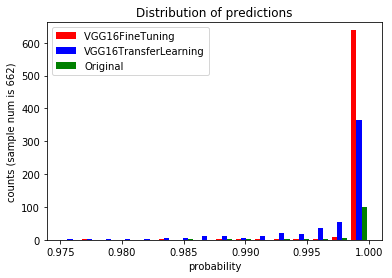

In [45]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# ax.hist(acc_dist11, bins=50,  color='red', alpha=0.5,range=(a_min, a_max),label='VGG16FineTuning')
# ax.hist(acc_dist22, bins=50,  color='blue',alpha=0.5,range=(a_min, a_max),label='VGG16TransferLearning')
# ax.hist(acc_dist33, bins=50,  color='green',alpha=0.5,range=(a_min, a_max),label='Original ')
# x = [acc_dist11,acc_dist22,acc_dist33]
x = [acc_dist1.reshape(-1,),acc_dist2.reshape(-1,),acc_dist3.reshape(-1,)]

ax.hist(x, bins=16,  color=['red', 'blue', 'green'],range=(a_min, a_max), label=label)
ax.set_ylim(0,662)
ax.set_title('Distribution of predictions')
ax.set_xlabel('probability')
ax.set_ylabel('counts (sample num is 662)')
plt.legend(loc='upper left')
fig.show()
plt.savefig("results_pictures/acc_dists.png")